In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold


# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

In [15]:
import sys
!{sys.executable} -m pip install pandas-profiling

     ------------------------------------ 324.4/324.4 kB 647.7 kB/s eta 0:00:00
     -------------------------------------- 344.9/344.9 kB 1.9 MB/s eta 0:00:00
     -------------------------------------- 102.7/102.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 663.5/663.5 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 296.5/296.5 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 2.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27082 sha256=1f912c88c028748bea21a262da2560690e85514419ef670566f6999df8fe29d9
  Stored in directory: c:\users\abhis\appdata\local\pip\cache\wheels\1d\05\04\c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [22]:
import pandas_profiling as pp

In [23]:
valid_part = 0.4

In [24]:
train0 = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\Python lecture\Ekeeda Miniprojects\BOD\train.csv')
train0.head(10)

,Id,target,1,2,3,4,5,6,7
0,0,5.85,4.80,5.85,NaN,NaN,NaN,NaN,NaN
1,3,4.28,5.88,6.84,NaN,NaN,NaN,NaN,NaN
2,4,3.97,3.20,2.70,NaN,NaN,NaN,NaN,NaN
3,5,5.95,7.70,7.06,NaN,NaN,NaN,NaN,NaN
4,6,4.70,5.50,5.30,NaN,NaN,NaN,NaN,NaN
5,7,4.36,4.91,4.48,NaN,NaN,NaN,NaN,NaN
6,8,3.74,3.71,3.76,NaN,NaN,NaN,NaN,NaN
7,9,7.70,3.75,3.60,NaN,NaN,NaN,NaN,NaN
8,10,3.34,2.13,5.40,NaN,NaN,NaN,NaN,NaN
9,11,3.96,2.24,4.22,NaN,NaN,NaN,NaN,NaN


In [25]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      147 non-null    int64  
 1   target  147 non-null    float64
 2   1       145 non-null    float64
 3   2       145 non-null    float64
 4   3       32 non-null     float64
 5   4       31 non-null     float64
 6   5       33 non-null     float64
 7   6       37 non-null     float64
 8   7       37 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 10.5 KB


In [26]:
pp.ProfileReport(train0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
train0 = train0.drop(['Id','3','4','5','6','7'], axis = 1)
train0 = train0.dropna()
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 146
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  144 non-null    float64
 1   1       144 non-null    float64
 2   2       144 non-null    float64
dtypes: float64(3)
memory usage: 4.5 KB


In [28]:
train0.head(3)

,target,1,2
0,5.85,4.80,5.85
1,4.28,5.88,6.84
2,3.97,3.20,2.70


In [29]:
target_name = 'target'


In [31]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [32]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [33]:
plotPerColumnDistribution(train0 , 10, 5)

<Figure size 2400x512 with 0 Axes>

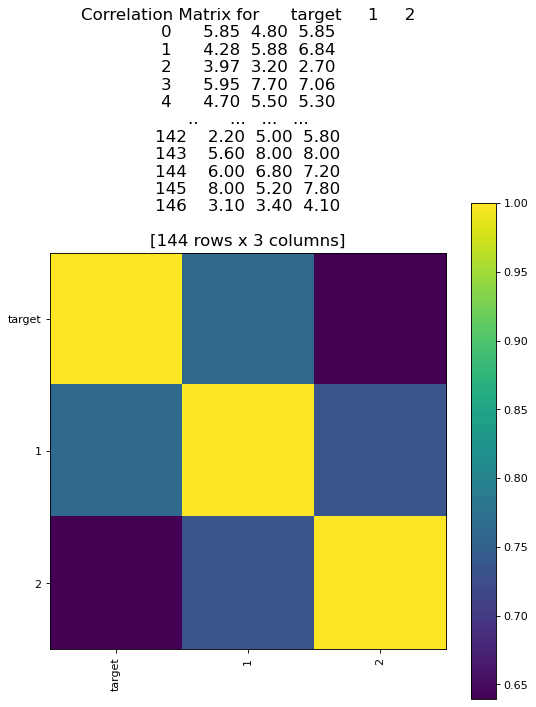

In [34]:
plotCorrelationMatrix(train0, 8)

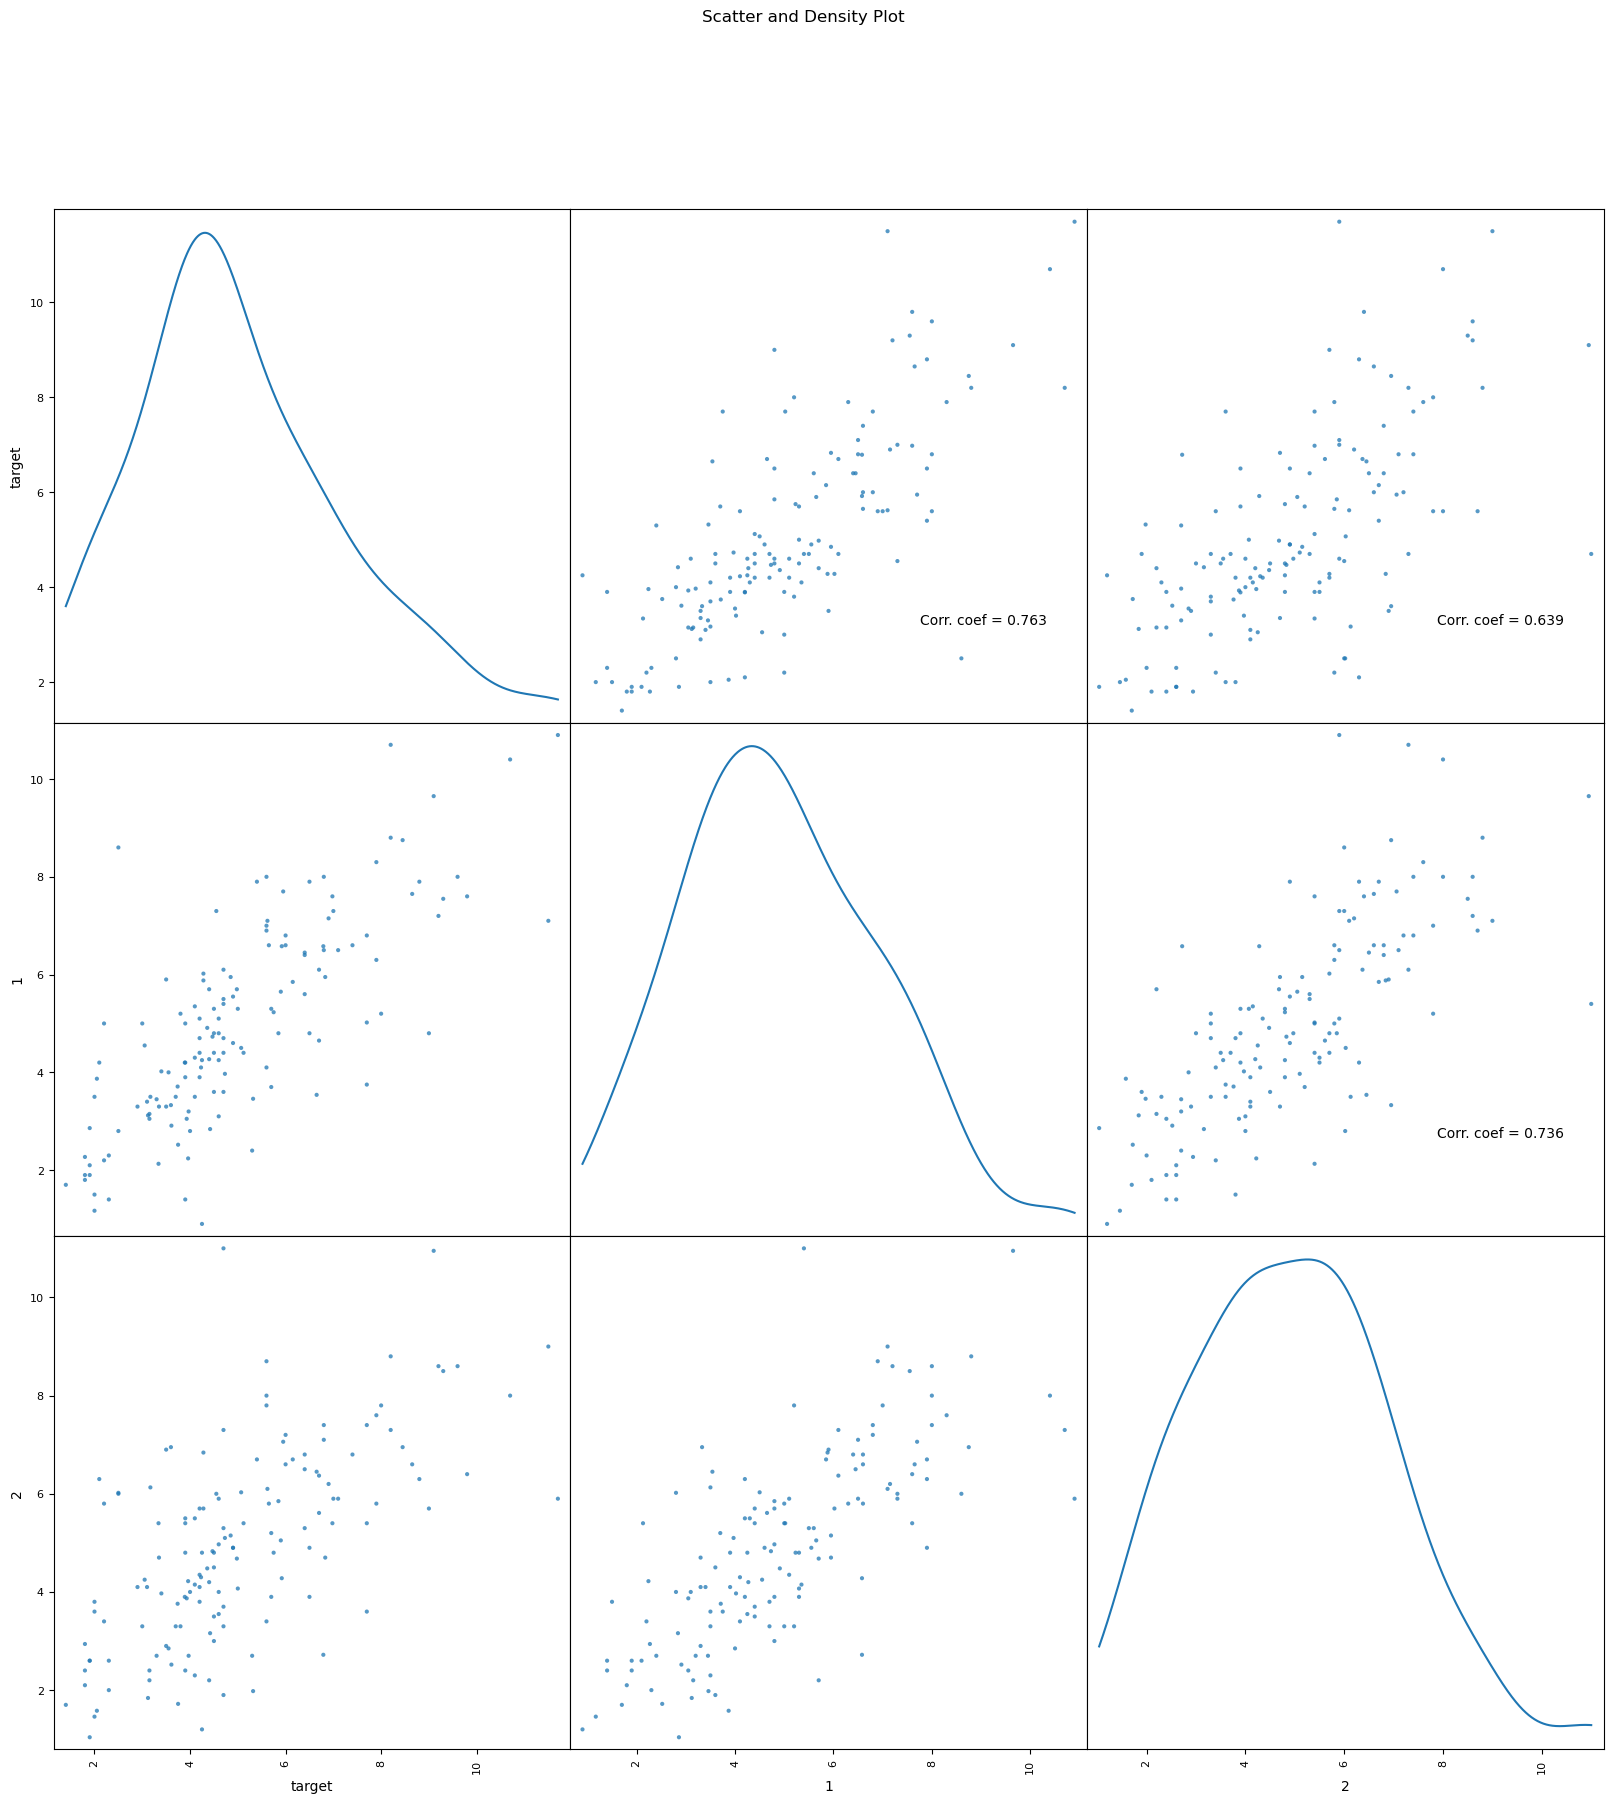

In [35]:
plotScatterMatrix(train0 , 20, 10)

In [36]:
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [37]:
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [38]:
train0.head(3)

,1,2
0,-0.085038,0.464653
1,0.443331,0.963267
2,-0.867807,-1.121847


In [39]:
len(train0)

144

In [40]:
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [41]:
train.head(3)

,1,2
13,1.260347,1.799328
142,0.110655,1.446772
100,2.287732,3.033272


In [42]:
test.head(3)

,1,2
7,-0.598730,-0.668561
89,-1.993038,-1.877323
97,-0.466638,-0.482211


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 13 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       86 non-null     float64
 1   2       86 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 7 to 73
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       58 non-null     float64
 1   2       58 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


In [45]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [46]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [47]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [48]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [49]:
linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [7.23652962 5.62699656 9.03493746 6.92413148 7.03712652]
acc(r2_score) for train = 56.42
acc(relative error) for train = 20.65
acc(rmse) for train = 134.15
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [3.89016017 1.63203432 4.13223958 6.0659371  4.96206592]
acc(r2_score) for test = 61.0
acc(relative error) for test = 18.6
acc(rmse) for test = 136.68


In [50]:
svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [7.29377052 5.68593743 6.8110463  6.2356463  7.26652707]
acc(r2_score) for train = 53.64
acc(relative error) for train = 20.8
acc(rmse) for train = 138.37
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [3.86457396 2.76427554 4.07683595 5.65914487 4.4691795 ]
acc(r2_score) for test = 44.77
acc(relative error) for test = 22.43
acc(rmse) for test = 162.65


In [51]:
linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [6.73411175 4.9426933  8.36887316 6.77446492 6.47110214]
acc(r2_score) for train = 54.25
acc(relative error) for train = 20.4
acc(rmse) for train = 137.46
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [3.76729609 1.56588836 3.97850223 5.89116791 4.60094425]
acc(r2_score) for test = 56.66
acc(relative error) for test = 19.27
acc(rmse) for test = 144.08


In [52]:
mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [ 7.67822181  5.21036368 10.71634811  6.99076575  7.38161889]
acc(r2_score) for train = 50.49
acc(relative error) for train = 23.4
acc(rmse) for train = 143.0
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [3.24169889 2.5090447  3.30771919 5.59179816 3.86821196]
acc(r2_score) for test = 43.78
acc(relative error) for test = 22.28
acc(rmse) for test = 164.09


In [53]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [9.3  8.   9.1  8.65 9.2 ]
acc(r2_score) for train = 100.0
acc(relative error) for train = 0.0
acc(rmse) for train = 0.0
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [3.74 2.   3.74 7.   6.7 ]
acc(r2_score) for test = 26.91
acc(relative error) for test = 25.89
acc(rmse) for test = 187.1


In [54]:
random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest.fit(train, target)
print(random_forest.best_params_)
acc_model(6,random_forest,train,test)

{'n_estimators': 1000}
target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [8.9852  6.53423 9.33895 7.74055 8.6786 ]
acc(r2_score) for train = 91.1
acc(relative error) for train = 9.15
acc(rmse) for train = 60.63
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [4.07951 2.35459 4.21492 6.11607 5.27556]
acc(r2_score) for test = 50.47
acc(relative error) for test = 21.09
acc(rmse) for test = 154.02


In [57]:
Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [9.3  8.   9.1  8.65 9.2 ]
ytrain =  [8.54166667 7.03636364 9.1        7.27777778 8.54166667]
acc(r2_score) for train = 81.51
acc(relative error) for train = 15.53
acc(rmse) for train = 87.38
target_test = [7.7  4.25 3.4  7.1  9.  ]
ytest = [4.45358491 2.46       4.61513514 5.76238095 4.98407407]
acc(r2_score) for test = 47.64
acc(relative error) for test = 22.0
acc(rmse) for test = 158.35


In [64]:
testn = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\Python lecture\Ekeeda Miniprojects\BOD\test.csv')
testn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      63 non-null     int64  
 1   1       63 non-null     float64
 2   2       63 non-null     float64
 3   3       15 non-null     float64
 4   4       15 non-null     float64
 5   5       16 non-null     float64
 6   6       14 non-null     float64
 7   7       14 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 4.1 KB


In [65]:
testn = testn.drop(['Id','3','4','5','6','7'], axis = 1)
testn.head(3)

,1,2
0,6.80,5.4
1,4.71,4.2
2,2.10,3.4


In [66]:
testn = pd.DataFrame(scaler.transform(testn), columns = testn.columns)

In [67]:
linreg.fit(train0, train_target0)
linreg.predict(testn)[:3]

array([6.33565611, 4.73935886, 2.87220788])